In [22]:
%load_ext autoreload
%autoreload 2

In [23]:
import gdown
import pandas as pd
import os

#forcasting
from forecasting.utils.data import AddImmutable
from forecasting.forcasting import ARIMAModelHandler, LSTMModelHandler, TFTModelHandler
from forecasting.utils.utils import *

#generation
from genrisk.generation.tcn_gan import TCNGAN
from genrisk.utils.evaluation import *

#worst-risk case
from genrisk.shift import *
from genrisk.utils.utils import *

## Load dataset

In [25]:
def load_gas_supply():
    if not os.path.exists("gas_supply.csv"):
        gdown.download(
            "https://drive.google.com/uc?id=1kGp65UabcFcKAHSM4K2MgkPAYgbyhQj5",
            "gas_supply.csv",
        )
    target = pd.read_csv(
        "gas_supply.csv",
        skiprows=5,
        header=None,
        date_parser=pd.to_datetime,
        index_col=0,
    )
    target = target.sort_index().asfreq("W-Fri")
    target = target.rename(columns={1: "supply"})
    target.index.name = "date"
    target = target.iloc[:1500]
    return target

In [26]:
df_gas = load_gas_supply()

## Data preparation

add exogenous variable

In [27]:
df = AddImmutable(df_gas, ['weekofyear'])

In [28]:
df = df.get()

## Forcasting model

это чинит матплотлиб

In [29]:
import matplotlib.pyplot as plt

plt.style.use('default')
plt.rcParams['axes.grid'] = False

training model

In [30]:
arima = ARIMAModelHandler(dataset = df, 
                          test_percent = 0.1, 
                          forecasting_horizont = 24,
                          target_columns = ['supply'],
                          conditional_columns = ['weekofyear_cos', 'weekofyear_sin'],)
arima.train_model()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=-2506.884, Time=0.21 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=-2855.124, Time=1.67 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=-3167.552, Time=2.60 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=-2508.845, Time=0.32 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=-3157.193, Time=1.23 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=-3165.055, Time=3.86 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=-3165.728, Time=5.61 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=-3167.152, Time=2.45 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=-3163.727, Time=5.96 sec
 ARIMA(0,1,0)(0,0,1)[7] intercept   : AIC=-2510.472, Time=1.06 sec
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=-3176.746, Time=2.66 sec
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=-3170.773, Time=2.37 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=-3174.615, Time=3.18 sec
 ARIMA(1,1,1)(0,0,2)[7] intercept   : AIC=-3174.747, Time=5.22 sec
 ARIMA(1,1,1)(1,0,0

get prediction

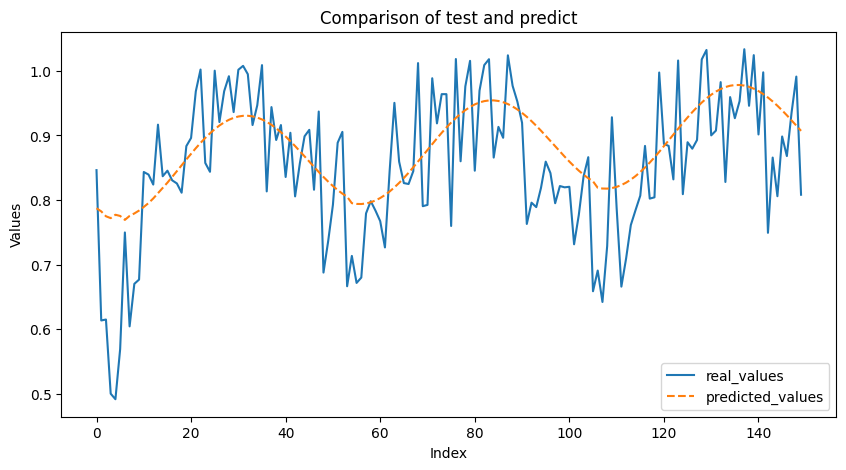

In [32]:
test_ts_values = list(arima.get_true_test().values) 
ans_values = list(arima.predict().values)  

plot_predictions(ans_values, test_ts_values) 

In [33]:
future_pred, future_target = arima.backtest()

plot_predictions(list(future_pred), list(future_target)) 

ValueError: For the given forecasting horizon `n=24`, the provided `future_covariates` series must contain at least the next `n=24` time steps/indices after the end of the target `series` that was used to train the model.


0
24
48
72
96
120


ValueError: For the given forecasting horizon `n=24`, the provided `future_covariates` series must contain at least the next `n=24` time steps/indices after the end of the target `series` that was used to train the model.

----

In [36]:
lstm = LSTMModelHandler(dataset = df, 
                          test_percent = 0.1, 
                          forecasting_horizont = 24,
                          target_columns = ['supply'],
                          conditional_columns = ['weekofyear_cos', 'weekofyear_sin'],)
lstm.train_model()

Training on CPU.


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 3.0 K 
4 | V             | Linear           | 26    
---------------------------------------------------
3.0 K     Trainable params
0         Non-trainable params
3.0 K     Total params
0.012     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


get prediction on the backtest

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


0


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


24
48


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


72
96
120


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


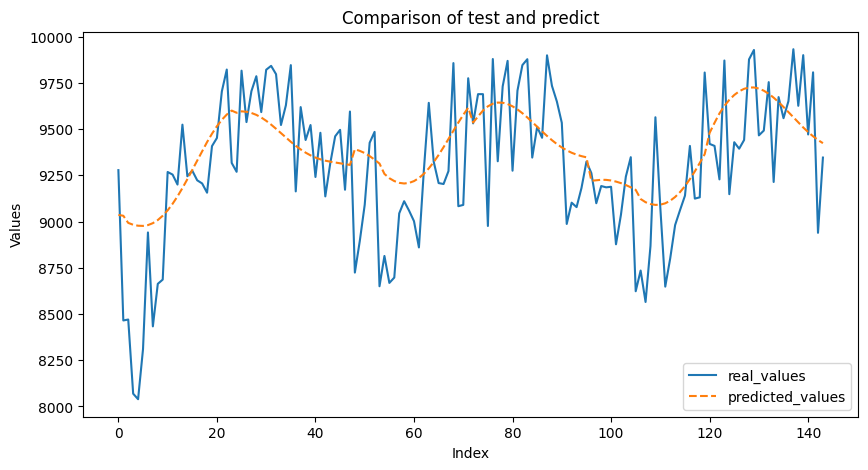

In [38]:
future_pred, future_target = lstm.backtest()

plot_predictions(list(future_pred), list(future_target)) 

get prediction

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


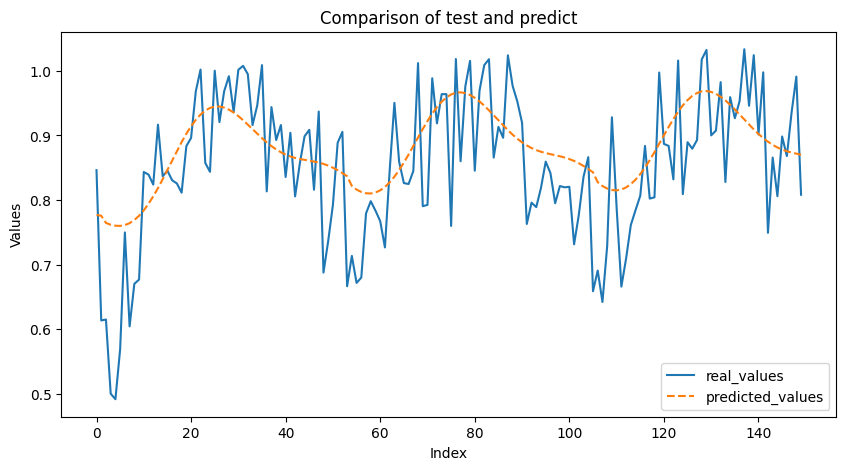

In [40]:
ans = lstm.predict()

test_ts_values = list(lstm.get_true_test().values) 
ans_values = list(ans.values)  

plot_predictions(ans_values, test_ts_values) 

---

In [41]:
tft = TFTModelHandler(dataset = df, 
                          test_percent = 0.1, 
                          forecasting_horizont = 24,
                          target_columns = ['supply'],
                          conditional_columns = ['weekofyear_cos', 'weekofyear_sin'],)
tft.train_model()

GPU available: False, used: False


Training on CPU.


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | _VariableSelectionNetwork        | 1.8 K 
5  | decoder_vsn                       | _VariableSelectionNetwork        | 1.2 K 
6  | static_context_grn                | _GatedResidualNetwork            | 1.1 K 
7  | static_context_hidden_encoder_grn | _GatedResidualNetwork            | 1.1 K 
8  | static_context_cell_encoder_grn   | _GatedRes

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

get prediction on the backtest

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


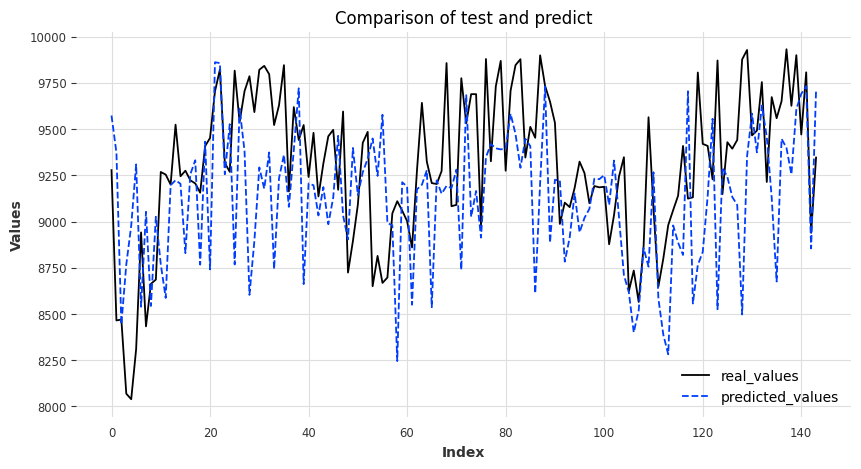

In [ ]:
tft.load_model()

future_pred, future_target = tft.backtest()

plot_predictions(list(future_pred), list(future_target)) 

get prediction

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


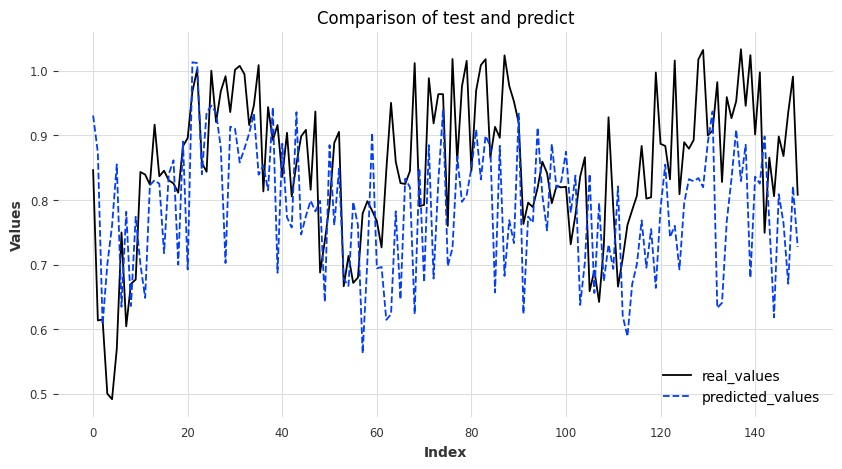

In [ ]:
ans = tft.predict()

test_ts_values = list(tft.get_true_test().values) 
ans_values = list(ans.values)  

plot_predictions(ans_values, test_ts_values) 

## Generation

prepare data to needed format

In [64]:
test_df = test_ts.pd_dataframe()
test_cov_df = test_cov.pd_dataframe()

In [65]:
result_df = pd.merge(
        test_df, test_cov_df, left_index=True, right_index=True
    )

create and fit the model

In [72]:
gen = TCNGAN(
            target_columns=test_df.columns,
            conditional_columns=test_cov_df.columns,
            window_size=100,
            num_epochs=80,
            num_layers=1,
            hidden_dim=64,
            latent_dim=2,
            verbose=True,
            lr=0.01,
            loss_type='Wasseerstein',
        )

In [14]:
gen.fit(result_df)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type              | Params
-------------------------------------------
0 | gen  | _TCNGenerator     | 13.6 K
1 | disc | _TCNDiscriminator | 13.3 K
-------------------------------------------
26.9 K    Trainable params
0         Non-trainable params
26.9 K    Total params
0.108     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=80` reached.


example of saving and loading

In [17]:
gen.save_model('D:/genrisk/generation_models/gen.pth')

In [73]:
gen.load_model('D:/genrisk/generation_models/gen.pth')

plot fake data

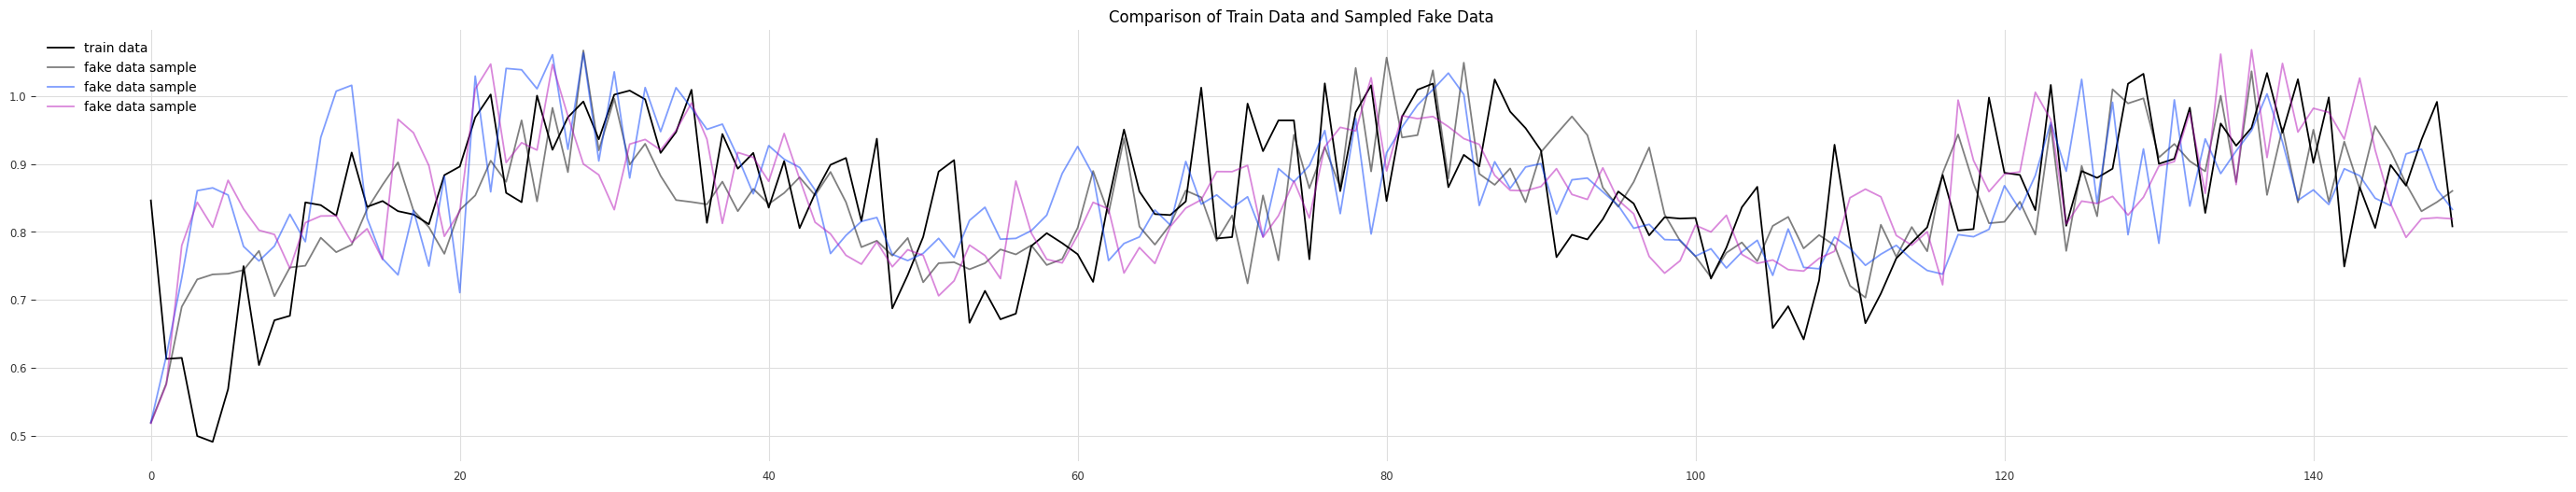

In [93]:
col = 'supply'
n_samples = 3

plot_fake_data(result_df, gen, col=col, n_samples=n_samples)

### Evaluation of generative model

prepare data

In [99]:
fake_data = gen.sample(result_df, n_samples=n_samples)

In [27]:
fake_evl = fake_data[0]['supply']
true_evl = result_df['supply']

different techniques to evaluate

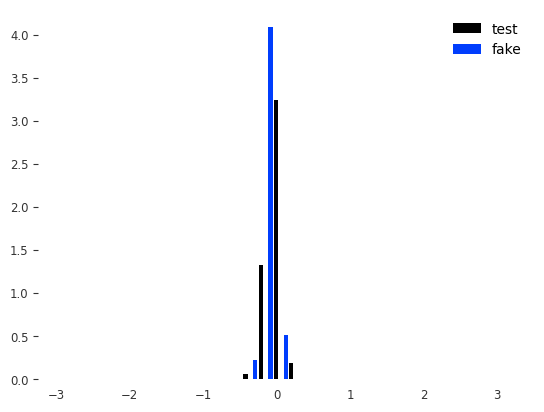

In [30]:
hist2samp(true_evl, fake_evl, 'test', 'fake', nbins=30)

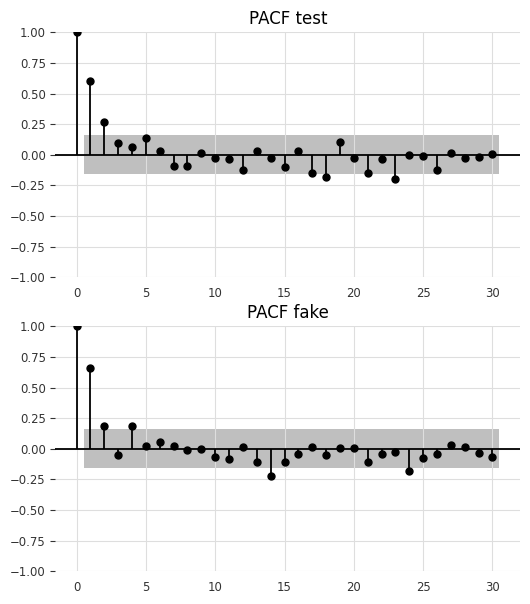

In [31]:
pacf2samp(true_evl, fake_evl, 'test', 'fake', nlags=30)

In [32]:
pacf_error(true_evl, fake_evl)

0.008894271170294524

In [35]:
ks_test(true_evl, fake_evl)

0.4425235033915137

In [40]:
ks_lags_test(true_evl, fake_evl)

0.2873685738507549

## Worsk-case risk

create model for finding shifts

In [66]:
shift_model = ConditionalShift(
    mutable_columns=list(test_df.columns),
    immutable_columns=list(test_cov_df.columns),
    alpha_space=np.linspace(0.05, 0.95, 10),
    cv=5,
    # mode = 'gbr_quantiles'
)

examles to plot only fake or real worsk-case risk data

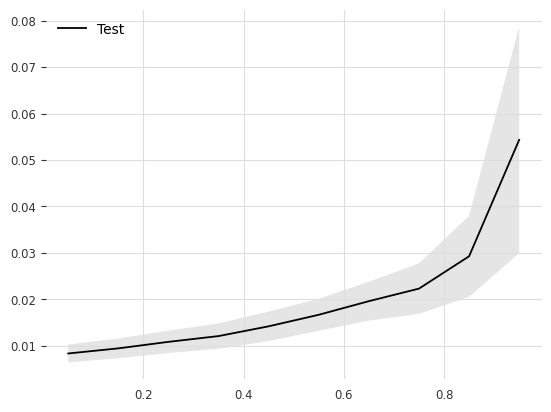

In [98]:
arima = ARIMAModelHandler()
ans = arima.predict(test_cov, len(test_ts))

plot_test_wcr(ans, shift_model, test_ts, result_df)

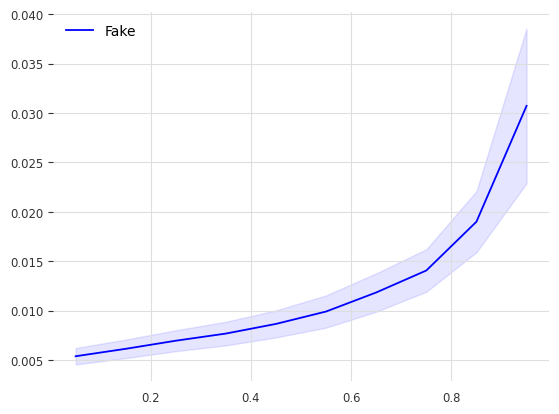

In [89]:
arima = ARIMAModelHandler()
ans = arima.predict(test_cov, len(test_ts))

plot_fake_wcr(ans, shift_model, fake_data, col)

plot comparison of both (fake and real) worst-case risk

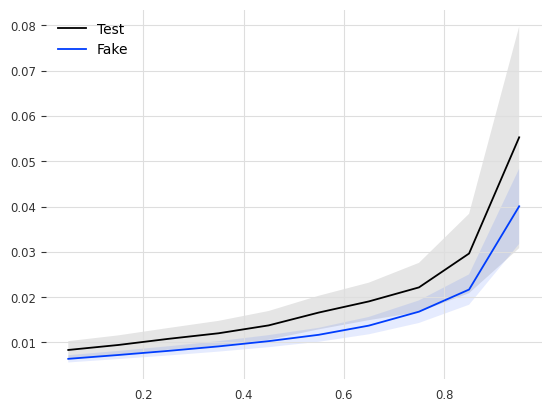

In [100]:
arima = ARIMAModelHandler()
ans = arima.predict(test_cov, len(test_ts))

plot_pair_wcr(ans,
    shift_model,
    test_ts,
    result_df,
    fake_data,
    col)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


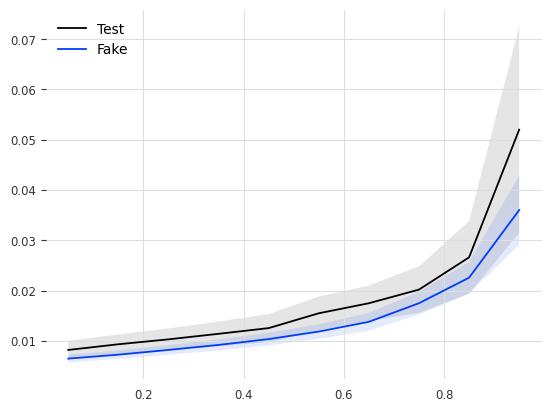

In [80]:
lstm = LSTMModelHandler()
ans = lstm.predict(train_ts, train_cov, test_cov, len(test_ts))
plot_pair_wcr(ans,
    shift_model,
    test_ts,
    result_df,
    fake_data,
    col)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


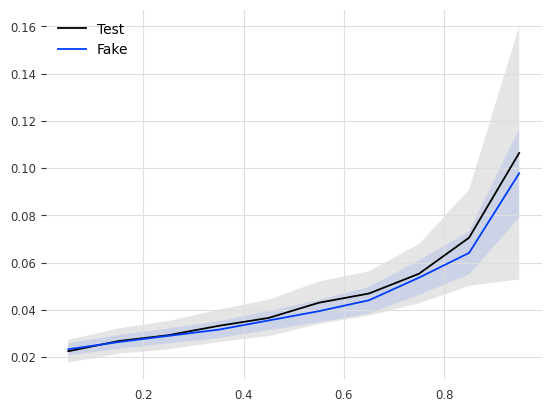

In [81]:
tft = TFTModelHandler()
ans = tft.predict(train_ts, train_cov, test_cov, len(test_ts))
plot_pair_wcr(ans,
    shift_model,
    test_ts,
    result_df,
    fake_data,
    col)